# Automated Rubik's cube solver

In [11]:
import numpy as np
import cv2
from rubik.cube import Cube
from rubik.solve import Solver
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
images_path = './images/'

### Prepare image
- Gaussian blur (with 7x7 kernel)
- Canny edge detection (in range 20-40)
- Edge dilation (3x3 kernel, 4 iterations)

In [12]:
def prepare_image(image):
    image = cv2.GaussianBlur(image, (7,7), 0)
    canny = cv2.Canny(image, 20, 40)
    dilated = cv2.dilate(canny, np.ones((3,3), np.uint8), iterations=4)
    return dilated

### Choose best contours
- Find all contours
- Calculate their centers and areas
- Return sorted contours

In [13]:
def get_contours(image, min_area, max_area):
    (contours, hierarchy) = cv2.findContours(image.copy(),
                                         cv2.RETR_TREE,
                                         cv2.CHAIN_APPROX_SIMPLE)
    candidates = []
    hierarchy = hierarchy[0]
    index = 0
    center = []
    for component in zip(contours, hierarchy):
        contour = component[0]
        area = cv2.contourArea(contour)
        M = cv2.moments(contour)
        if M["m00"]:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX = None
            cY = None
        if min_area < area < max_area and cX is not None:
            tmp = {'index': index, 'cx': cX, 'cy': cY, 'contour': contour}
            center.append(tmp)
            index += 1

    # cuts out 9 contours
    center.sort(key=lambda k: (k.get('cy', 0)))
    row1 = center[0:3]
    row1.sort(key=lambda k: (k.get('cx', 0)))
    row2 = center[3:6]
    row2.sort(key=lambda k: (k.get('cx', 0)))
    row3 = center[6:9]
    row3.sort(key=lambda k: (k.get('cx', 0)))

    center.clear()
    center = row1 + row2 + row3

    for component in center:
        candidates.append(component.get('contour'))
    return candidates

### Get average colour for each square
- Convert to HSV
- Calculate average using a mask for each contour

In [14]:
def get_square_colours(contours, image):
    avg_colours = []
    for i in range(9):
        mask = np.zeros(image.shape[:2], np.uint8)
        cv2.drawContours(mask, contours, i, 255, -1)
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        mean = cv2.mean(hsv, mask=mask)
        avg_colours.append(np.asarray(mean[0:3]))
    avg_colours = np.array(avg_colours)
    avg_colours[:,0] = avg_colours[:,0]*2
    avg_colours[:,1] = avg_colours[:,1]*100/255
    avg_colours[:,2] = avg_colours[:,2]*100/255
    return avg_colours

### Match colours
- Define ranges
- Match colour according to hue values (except for white - S value)

In [15]:
white_s = 30
yellow = [31,90]
orange = [11,30]
red_l = [0,10.99]
red_r = [230,360]
green = [91,180]
blue = [190,220]

def get_nearest_colour(value):
    """
    """
    h = value[0]
    s = value[1]
    if s < white_s:
        return "W"
    elif yellow[0] <= h <= yellow[1]:
        return "Y"
    elif orange[0] <= h <= orange[1]:
        return "O"
    elif red_l[0] <= h <= red_l[1] or red_r[0] <= h <= red_r[1]:
        return "R"
    elif green[0] <= h <= green[1]:
        return "G"
    elif blue[0] <= h <= blue[1]:
        return "B"
    else:
        return "?"

### Convert dictionary to string
- The order of middle row values is different that in the dictionary

In [16]:
def get_cube_string(model):
    cube_string = ""
    cube_string += "".join(model["U"])
    top = ""
    middle = ""
    bottom = ""
    for n in ["L","F","R","B"]:
        top +="".join(model[n][:3])
        middle +="".join(model[n][3:6])
        bottom +="".join(model[n][6:])
    cube_string += (top+middle+bottom)
    cube_string += "".join(model["D"])
    return cube_string

### Build a model with colours
- Perform color recognition for a picture of each side
- Build a dictionary for sides
- Convert to string model required by external library

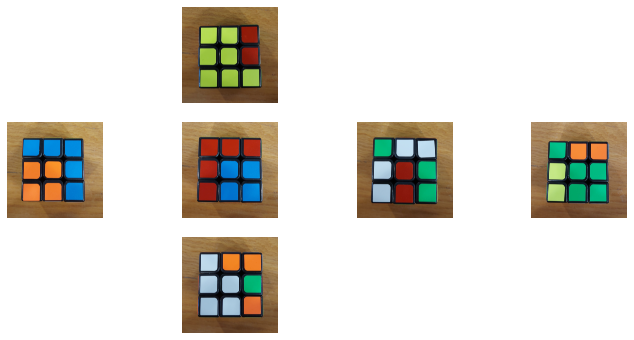

In [17]:
sides = ["U","L","F","R","B","D"]
model = {}
plots = [2,5,6,7,8,10]
# lighting = "dark/"
lighting = "light/"
for i in zip(sides,plots):
    side = i[0]
    plot_id = i[1]
    image = cv2.imread(images_path+lighting+side+".jpg")
    image_RGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(600,600))
    plt.subplot(3,4,plot_id)
    plt.axis('off')
    plt.imshow(image_RGB)
    prep = prepare_image(image)
    min_area, max_area = image.shape[0]*image.shape[1]/50,image.shape[0]*image.shape[1]/20
    contours = get_contours(prep, min_area, max_area)
    squares = get_square_colours(contours,image)
    colours = [get_nearest_colour(square) for square in squares]
    model[side] = colours
plt.savefig("model.png")

### Solve a given cube
- Build cube model and attempt to solve

In [18]:
c = Cube(get_cube_string(model))
print(c)
s = Solver(c)
try:
    s.solve()
    print("Proposed move is: ", " ".join(s.moves[0:8]),"...")
except:
    print("Invalid cube")

    YYR
    YYR
    YYY
BBB RRR GWW GOO
OOB RBB WRG YGG
OOB RBB WRG YGG
    WOO
    WWG
    WWO
Proposed move is:  Di Di B B B D D L ...


The best solution is **U F U' R' U'** - the inverse of this simple scramble. Not proposed by this solver

### Capture from webcam
- Example for recognising colors from webcam

In [19]:
def capture_image(title, save):
    videoCaptureObject = cv2.VideoCapture(0)
    upper_left = (170, 90)
    bottom_right = (470, 390)
    result = True
    while(result):
        ret,image_frame = videoCaptureObject.read()
        #Rectangle marker
        r = cv2.rectangle(image_frame, upper_left, bottom_right, (100, 50, 200), 3)

        img = image_frame[upper_left[1]+3:bottom_right[1]-3,upper_left[0]+3:bottom_right[0]-3]
        cv2.imshow("test", image_frame)
        k = cv2.waitKey(1)

        if k%256 == 27:
            print("Escape hit, closing...")
            break
        elif k%256 == 32:
            if save:
                cv2.imwrite(title, img)
                print("Image saved")
            result = False

    videoCaptureObject.release()
    cv2.destroyAllWindows()
    return img

In [24]:
image = capture_image("webcam_test.jpg",save=False)
prep = prepare_image(image)
min_area, max_area = image.shape[0]*image.shape[1]/50,image.shape[0]*image.shape[1]/20
contours = get_contours(prep, min_area, max_area)
squares = get_square_colours(contours,image)
colours = [get_nearest_colour(square) for square in squares]
print(colours)
cv2.drawContours(image, contours, -1, (0, 0, 255), 3)
cv2.imshow("webcam test",image)
cv2.waitKey(0)
cv2.destroyAllWindows()

['G', 'R', 'W', 'G', 'R', 'B', 'B', 'B', 'G']
